**Prep Data**

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score

%matplotlib inline

In [27]:
# read in metadata w genre labels

tracks = pd.read_csv('fma-rock-vs-hiphop.csv')
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17734 entries, 0 to 17733
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   track_id       17734 non-null  int64 
 1   bit_rate       17734 non-null  int64 
 2   comments       17734 non-null  int64 
 3   composer       166 non-null    object
 4   date_created   17734 non-null  object
 5   date_recorded  1898 non-null   object
 6   duration       17734 non-null  int64 
 7   favorites      17734 non-null  int64 
 8   genre_top      17734 non-null  object
 9   genres         17734 non-null  object
 10  genres_all     17734 non-null  object
 11  information    482 non-null    object
 12  interest       17734 non-null  int64 
 13  language_code  4089 non-null   object
 14  license        17714 non-null  object
 15  listens        17734 non-null  int64 
 16  lyricist       53 non-null     object
 17  number         17734 non-null  int64 
 18  publisher      52 non-null

In [28]:
# read in metadata with metrics for features

trackmetrics = pd.read_json('echonest-metrics.json', precise_float=True)
trackmetrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13129 entries, 0 to 13128
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          13129 non-null  int64  
 1   acousticness      13129 non-null  float64
 2   danceability      13129 non-null  float64
 3   energy            13129 non-null  float64
 4   instrumentalness  13129 non-null  float64
 5   liveness          13129 non-null  float64
 6   speechiness       13129 non-null  float64
 7   tempo             13129 non-null  float64
 8   valence           13129 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.0 MB


In [29]:
# merge relevant (corresponding) cols from both files
# merges on trackmetrics & adds genre_top from tracks

echotracks = trackmetrics.merge(tracks[['track_id', 'genre_top']], on='track_id')
echotracks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


**Exploring Pairwise Relationships Between Continuous Variables**

In [30]:
# correlation matrix to see which features correlate most
# nothing more than .50 so none

correlation = echotracks.corr()
correlation.style.background_gradient()

,track_id,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
track_id,1.000000,-0.372282,0.049454,0.140703,-0.275623,0.048231,-0.026995,-0.025392,0.010070
acousticness,-0.372282,1.000000,-0.028954,-0.281619,0.194780,-0.019991,0.072204,-0.026310,-0.013841
danceability,0.049454,-0.028954,1.000000,-0.242032,-0.255217,-0.106584,0.276206,-0.242089,0.473165
energy,0.140703,-0.281619,-0.242032,1.000000,0.028238,0.113331,-0.109983,0.195227,0.038603
instrumentalness,-0.275623,0.194780,-0.255217,0.028238,1.000000,-0.091022,-0.366762,0.022215,-0.219967
liveness,0.048231,-0.019991,-0.106584,0.113331,-0.091022,1.000000,0.041173,0.002732,-0.045093
speechiness,-0.026995,0.072204,0.276206,-0.109983,-0.366762,0.041173,1.000000,0.008241,0.149894
tempo,-0.025392,-0.026310,-0.242089,0.195227,0.022215,0.002732,0.008241,1.000000,0.052221
valence,0.010070,-0.013841,0.473165,0.038603,-0.219967,-0.045093,0.149894,0.052221,1.000000


**Normalize Feature Data** - Processing the data

In [34]:
# define features

features = echotracks.drop(['track_id', 'genre_top'], axis=1)

In [35]:
# define labels

labels = echotracks['genre_top']

In [36]:
# where you use sklearn.preprocessing - StandardScaler
# scale features & set values to a new variable
# fit_transform - fit to data then transforms it

scaler = StandardScaler()
scaledtrain_features = scaler.fit_transform(features)

**PCA, Principal Component Analysis**

To find # features to use further

**Scree-plot**

In [38]:
# where using matplotlib, sklearn.decomposition-PCA
# find explained variance ratios from PCA using all features

pca = PCA()
pca.fit(scaledtrain_features)
exp_variance = pca.explained_variance_ratio_

<BarContainer object of 8 artists>

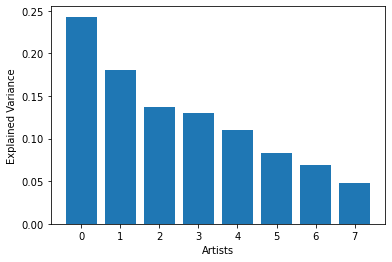

In [39]:
# plot the variance

fig, ax = plt.subplots()
plt.xlabel('Artists')
plt.ylabel('Explained Variance')
ax.bar(range(pca.n_components_), exp_variance)

**Cumulative Explained Variance Plot**

To find # features with 90% variance (can change). Once right # features, perform PCA.

In [40]:
# where using numpy
# calc CEV

cum_exp_variance = np.cumsum(exp_variance)

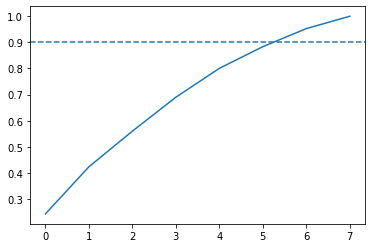

In [43]:
# plot CEV + draw dashed line at .90

fig, ax = plt.subplots()
ax.plot(range(8), cum_exp_variance)
ax.axhline(y=.9, linestyle='--')
n_components = 6

**PCA w new info**

In [44]:
# PCA w chosen n_components & project data

pcal = PCA(n_components)
pcal.fit(scaledtrain_features)
projection = pcal.transform(scaledtrain_features)

NOTES:

I don't exactly understand how the above has 'reduced the dimensions' of the dataset

**Train Decision Tree to Classify Genre**

In [45]:
# where using sklearn.model_selection, sklearn.tree
# split data

train_fts, test_fts, train_labels, test_labels = train_test_split(projection, labels)

In [48]:
# train Decision Tree
# to obtain deterministic behavior during fitting, random_state has to be a fixed integer

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_fts, train_labels)

DecisionTreeClassifier(random_state=10)

In [50]:
# predict labels for test data

predlabels_tree = tree.predict(test_fts)
print(predlabels_tree)

['Hip-Hop' 'Hip-Hop' 'Rock' ... 'Rock' 'Hip-Hop' 'Rock']


**Compare Decision Tree to Logistic Regression**

**Train Logistic Regression to Classify Genre**

In [51]:
# where using sklearn.linear_model
# train logistic Regression

logreg = LogisticRegression()
logreg.fit(train_fts, train_labels)

LogisticRegression()

In [53]:
predlabels_logreg = logreg.predict(test_fts)
print(predlabels_logreg)

['Hip-Hop' 'Rock' 'Rock' ... 'Rock' 'Rock' 'Rock']


In [54]:
#where using sklearn.metrics-classification_report
# create classification report for both models

classreport_tree = classification_report(test_labels, predlabels_tree)
classreport_log = classification_report(test_labels, predlabels_logreg)

In [55]:
print("Decision Tree: \n", classreport_tree)
print("Logistic Regression: \n", classreport_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.61      0.62      0.61       227
        Rock       0.91      0.91      0.91       974

    accuracy                           0.85      1201
   macro avg       0.76      0.76      0.76      1201
weighted avg       0.85      0.85      0.85      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.80      0.50      0.62       227
        Rock       0.89      0.97      0.93       974

    accuracy                           0.88      1201
   macro avg       0.85      0.74      0.77      1201
weighted avg       0.88      0.88      0.87      1201



Both have about 87% precision (accuracy). HipHip more miss-classified than Rock.

**Balance Data for Greater Performance**

Weight value of a correct classification in each class inversely to the occurance of data points for each class. Account for differences in sample size.

In [56]:
# subset hiphop & rock separately

rockonly = echotracks.loc[echotracks['genre_top']=='Rock']
hiponly = echotracks.loc[echotracks['genre_top']=='Hip-Hop']

In [59]:
# rock sample should be same # as hiphop sample

rockonly = rockonly.sample(len(hiponly), random_state=10)

In [60]:
# concat (merge) rockonly & hiponly DFs

rockhopbal = pd.concat([hiponly, rockonly])

In [61]:
# re-define train & test data

features, labels = rockhopbal.drop(['genre_top', 'track_id'], axis=1), rockhopbal['genre_top']
train_fts, test_fts, train_labels, test_labels = train_test_split(features, labels, random_state=10)

**Confirm If Balancing Dataset Improves Model Bias**

In [62]:
# train Decision Tree on balanced data

tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_fts, train_labels)

DecisionTreeClassifier(random_state=10)

In [63]:
# predict labels for test data

predlabels_tree = tree.predict(test_fts)

In [64]:
# train Logistic Regression with balanced data

logreg = LogisticRegression(random_state=10)
logreg.fit(train_fts, train_labels)

C:\Users\Haven\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=10)

In [65]:
# predict labels for test data

predlabels_log = logreg.predict(test_fts)

In [66]:
# compare models using classification report

print("Decision Tree: \n", classification_report(test_labels, predlabels_tree))
print("Logistic Regression: \n", classification_report(test_labels, predlabels_log))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.85      0.83      0.84       225
        Rock       0.84      0.86      0.85       230

    accuracy                           0.84       455
   macro avg       0.84      0.84      0.84       455
weighted avg       0.84      0.84      0.84       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.85      0.84      0.84       225
        Rock       0.84      0.85      0.85       230

    accuracy                           0.85       455
   macro avg       0.85      0.85      0.85       455
weighted avg       0.85      0.85      0.85       455



**Cross Validation to Evaluation Models**

using **KFold Cross Validation**

In [67]:
# where using sklearn.model_selection
# set up K-Fold Cross-Val

kf =KFold(n_splits=10, random_state=10)

C:\Users\Haven\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [68]:
# train models using KF C-V

treescore = cross_val_score(tree, features, labels, cv=kf)
logscore = cross_val_score(logreg, features, labels, cv=kf)

C:\Users\Haven\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Haven\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [74]:
# print mean of each array of scores

print(" Decision Tree: ", np.mean(treescore), "\n", "Logistic Regression: ", np.mean(logscore))

 Decision Tree:  0.8274725274725274 
 Logistic Regression:  0.8104395604395606
